In [1]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.transform import resize
from skimage.measure import block_reduce
import tensorflow as tf
#from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import where
import tensorflow_addons as tfa
from tensorflow.keras import Model, Input
#In this competition tensorflow is not updated, then we use keras to load model and weights
from keras.models import model_from_json, load_model
import json

In [2]:
import pydicom
import os
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error

In [3]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
#DESIRED_SIZE = 256 # Memory issue
DESIRED_SIZE = 128

In [4]:
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [5]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [6]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [7]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [8]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [9]:
COLS = ['Sex','SmokingStatus']
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
#=================

In [10]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [11]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [12]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

### Quick Image processing

In [13]:
def get_images(df, how="train"):
    xo = []
    p = []
    w  = []
    for i in tqdm(range(df.shape[0])):
        patient = df.iloc[i,0]
        week = df.iloc[i,1]
        try:
            img_path = f"{ROOT}/{how}/{patient}/{week}.dcm"
            ds = pydicom.dcmread(img_path)
            im = Image.fromarray(ds.pixel_array)
            im = im.resize((DESIRED_SIZE,DESIRED_SIZE)) 
            im = np.array(im)
            xo.append(im[np.newaxis,:,:])
            p.append(patient)
            w.append(week)
        except:
            pass
    data = pd.DataFrame({"Patient":p,"Weeks":w})
    return np.concatenate(xo, axis=0), data

In [14]:
x, df_tr = get_images(tr, how="train")

100%|██████████| 1535/1535 [00:23<00:00, 66.26it/s] 


In [15]:
x.shape, df_tr.shape

((1231, 128, 128), (1231, 2))

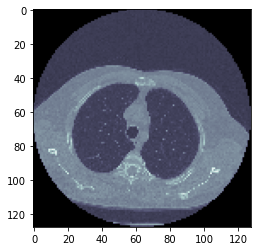

In [16]:
idx = np.random.randint(x.shape[0])
plt.imshow(x[idx], cmap=plt.cm.bone)
plt.show()

In [17]:
df_tr = df_tr.merge(tr, how="left", on=['Patient', 'Weeks'])

In [18]:
y = df_tr['FVC'].values
z = df_tr[FE].values

In [19]:
z.shape

(1231, 9)

### BASELINE CNN 

In [20]:
# import tensorflow.keras.backend as K
# import tensorflow.keras.layers as L
# import tensorflow.keras.models as M

In [21]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def kloss(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 1]
    fvc_pred = y_pred[:, 0]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#=============================#
def kmae(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    spread = tf.abs( (y_true[:, 0] -  y_pred[:, 0])  / y_true[:, 0] )
    #spred = tf.square(y_true, y_pred[:, 0])
    return K.mean(spread)
#=============================#

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * kloss(y_true, y_pred) + (1 - _lambda)*kmae(y_true, y_pred)
    return loss
#=================
# def make_model():
#     inp = L.Input((DESIRED_SIZE,DESIRED_SIZE), name="input")
#     z = L.Input((9,), name="Patient")
#     x = L.Conv1D(50, 4, activation="relu", name="conv1")(inp)
#     x = L.MaxPool1D(2, name='pool1')(x)
    
#     #x = L.Dropout(0.2)(x)
#     x = L.Conv1D(50, 4, activation="relu", name="conv2")(x)
#     x = L.MaxPool1D(2, name='pool2')(x)
    
#     #x = L.Dropout(0.2)(x)
#     x = L.Conv1D(50, 4, activation="relu", name="conv3")(x)
#     x = L.MaxPool1D(2, name='pool3')(x)
    
#     x = L.Flatten(name="features")(x)
#     x = L.Dense(50, activation="relu", name="d1")(x)
#     l = L.Dense(10, activation="relu", name="d2")(z)
#     x = L.Concatenate(name="combine")([x, l])
#     x = L.Dense(50, activation="relu", name="d3")(x)
#     preds = L.Dense(2, activation="relu", name="preds")(x)
    
#     model = M.Model([inp, z], preds, name="CNN")
#     model.compile(loss=mloss(0.5), optimizer="adam", metrics=[kloss])
#     #model.compile(loss=kmae, optimizer="adam", metrics=[kloss])
#     #model.compile(loss=kloss, optimizer="adam", metrics=[kmae])#
#     return model

### Modified VGG19 use like baseline model

In [22]:
def VGG19(x):
    
    #Block 1
    x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1', kernel_initializer='he_normal')(x)
    x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2', kernel_initializer='he_normal')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1', kernel_initializer='he_normal')(x)
    x = Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2', kernel_initializer='he_normal')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#     # Block 3
#     x = Conv2D(256, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block3_conv1', kernel_initializer='he_normal')(x)
#     x = Conv2D(256, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block3_conv2', kernel_initializer='he_normal')(x)
#     x = Conv2D(256, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block3_conv3', kernel_initializer='he_normal')(x)
#     x = Conv2D(256, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block3_conv4', kernel_initializer='he_normal')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#     # Block 4
#     x = Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block4_conv1', kernel_initializer='he_normal')(x)
#     x = Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block4_conv2', kernel_initializer='he_normal')(x)
#     x = Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block4_conv3', kernel_initializer='he_normal')(x)
#     x = Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block4_conv4', kernel_initializer='he_normal')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#     # Block 5
#     x = Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block5_conv1', kernel_initializer='he_normal')(x)
#     x = Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block5_conv2', kernel_initializer='he_normal')(x)
#     x = Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block5_conv3', kernel_initializer='he_normal')(x)
#     x = Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block5_conv4', kernel_initializer='he_normal')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

In [23]:
# Global Constants
LRN2D_NORM=True
DATA_FORMAT='channels_last' # Theano:'channels_first' Tensorflow:'channels_last'
USE_BN=True
DROPOUT=0.25
#weight_decay=0.01 #None
weight_decay=None

def conv2D_lrn2d(x,filters,kernel_size,strides=(1,1),padding='same',dilation_rate=(1,1),activation='relu',
                 use_bias=True,kernel_initializer='he_normal',bias_initializer='zeros',
                 kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,
                 kernel_constraint=None,bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=weight_decay):
    #l2 normalization
    if weight_decay:
        kernel_regularizer=tf.keras.regularizers.l1(weight_decay)
        bias_regularizer=tf.keras.regularizers.l1(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,dilation_rate=dilation_rate,
             activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
             bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
             activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    if lrn2d_norm:
        #batch normalization
        x=BatchNormalization()(x)

    return x

#Defining InceptionV1 module
def inception_module(x,params,concat_axis,padding='same',dilation_rate=(1,1),activation='relu',
                     use_bias=True,kernel_initializer='he_normal',bias_initializer='zeros',
                     kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,
                     bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=weight_decay):
    (branch1,branch2,branch3,branch4)=params
    if weight_decay:
        kernel_regularizer=tf.keras.regularizers.l1(weight_decay)
        bias_regularizer=tf.keras.regularizers.l1(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #1x1
    pathway1=Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    #1x1->3x3
    pathway2=Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2=Conv2D(filters=branch2[1],kernel_size=(3,3),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway2)
    #1x1->5x5
    pathway3=Conv2D(filters=branch3[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway3=Conv2D(filters=branch3[1],kernel_size=(5,5),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway3)
    #3x3->1x1
    pathway4=MaxPooling2D(pool_size=(3,3),strides=1,padding=padding,data_format=DATA_FORMAT)(x)
    pathway4=Conv2D(filters=branch4[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway4)

    return concatenate([pathway1,pathway2,pathway3,pathway4],axis=concat_axis)

In [24]:
#Defining conv2d_bn to inceptionv3_module
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), name=None):
    """Utility function to apply conv + BN.
    Arguments:
    x: input tensor.
    filters: filters in `Conv2D`.
    num_row: height of the convolution kernel.
    num_col: width of the convolution kernel.
    padding: padding mode in `Conv2D`.
    strides: strides in `Conv2D`.
    name: name of the ops; will become `name + '_conv'`
      for the convolution and `name + '_bn'` for the
      batch norm layer.
      Returns:
      Output tensor after applying `Conv2D` and `BatchNormalization`.
      """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    
    x = Conv2D(filters, (num_row, num_col),strides=strides,padding=padding,use_bias=False,name=conv_name)(x)
    x = BatchNormalization(scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    
    return x

In [25]:
channel_axis=3
def inceptionV3_module(x):
    x = conv2d_bn(x, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # mixed 0: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)
    
    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)
    
    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    
    branch_pool = AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                           axis=channel_axis,
                           name='mixed0')
    # mixed 1: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)
    
    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)
    
    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    
    branch_pool = AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                           axis=channel_axis,
                           name='mixed1')
    
    # mixed 2: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)
    
    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)
    
    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    
    branch_pool = AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                           axis=channel_axis,
                           name='mixed2')
    
    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')
    
    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')
    
    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch3x3dbl, branch_pool],
                           axis=channel_axis,
                           name='mixed3')
    
    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)
    
    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)
    
    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    
    branch_pool = AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                           axis=channel_axis,
                           name='mixed4')
    
    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)
        
        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)
        
        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
        
        branch_pool = AveragePooling2D((3, 3),
                                              strides=(1, 1),
                                              padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                               axis=channel_axis,
                               name='mixed' + str(5 + i))
        
    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)
    
    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)
    
    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    
    branch_pool = AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                           axis=channel_axis,
                           name='mixed7')
    
    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3, strides=(2, 2), padding='valid')
    
    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')
    
    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch7x7x3, branch_pool],
                           axis=channel_axis,
                           name='mixed8')
    
    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)
        
        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = concatenate([branch3x3_1, branch3x3_2],
                                       axis=channel_axis,
                                       name='mixed9_' + str(i))
        
        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = concatenate([branch3x3dbl_1, branch3x3dbl_2],
                                          axis=channel_axis)
        
        branch_pool = AveragePooling2D((3, 3),
                                              strides=(1, 1),
                                              padding='same')(x)
        
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool],
                               axis=channel_axis,
                               name='mixed' + str(9 + i))
        
        return x

In [26]:
CONCAT_AXIS=3

#Model InceptionV1

def InceptionV1():
    inp = Input((DESIRED_SIZE,DESIRED_SIZE,1), name="input")
    x = inception_module(inp, params=[(128,), (128, 192), (32, 96), (64,)], concat_axis=CONCAT_AXIS)  # 3b
    x = Flatten()(x)
    x = Dropout(DROPOUT)(x)
    preds = Dense(2, activation="relu", name="preds")(x)
    
    #model = tf.keras.Model([inp, z], preds, name="CNN")
    model = tf.keras.Model(inp, preds, name="CNN")
    #opt = tf.keras.optimizers.SGD(learning_rate=0.001)
    #opt = tfa.optimizers.LAMB(learning_rate=0.001)
    #opt = tfa.optimizers.SGDW(learning_rate=0.001,weight_decay=0.001, momentum=0.01) #weight_decay=0.001
    #opt = tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001), 100, 10)
    #opt=tfa.optimizers.AveragedOptimizerWrapper(tf.keras.optimizers.Adam(lr=0.001))
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
    opt=tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001))
    #model.compile(loss=mloss(0.5), optimizer="adam", metrics=[kloss])
    model.compile(loss=mloss(0.5), optimizer=opt, metrics=[kloss])
    #model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

In [27]:
CONCAT_AXIS=3

#Model GoogleNet_InceptionV1

def GoogleNet():
    inp = Input((DESIRED_SIZE,DESIRED_SIZE,1), name="input")
    z = Input((9,), name="Patient")
    #x = VGG19(inp)
    x = conv2D_lrn2d(inp, 64, (7, 7), 2, padding='same', lrn2d_norm=False)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    x = conv2D_lrn2d(x, 64, (1, 1), 1, padding='same', lrn2d_norm=False)

    x = conv2D_lrn2d(x, 192, (3, 3), 1, padding='same', lrn2d_norm=True)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

    x = inception_module(x, params=[(64,), (96, 128), (16, 32), (32,)], concat_axis=CONCAT_AXIS)  # 3a
    x = inception_module(x, params=[(128,), (128, 192), (32, 96), (64,)], concat_axis=CONCAT_AXIS)  # 3b
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
    
    x = inception_module(x, params=[(192,), (96, 208), (16, 48), (64,)], concat_axis=CONCAT_AXIS)  # 4a
    x = inception_module(x, params=[(160,), (112, 224), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4b
    x = inception_module(x, params=[(128,), (128, 256), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4c
    x = inception_module(x, params=[(112,), (144, 288), (32, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4d
    x = inception_module(x, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 4e
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

    x = inception_module(x, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5a
    x = inception_module(x, params=[(384,), (192, 384), (48, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5b
    x = AveragePooling2D(pool_size=(1, 1), strides=1, padding='valid')(x)

    x = Flatten()(x)
    x = Dropout(DROPOUT)(x)
    preds = Dense(2, activation="relu", name="preds")(x)
    
    #model = tf.keras.Model([inp, z], preds, name="CNN")
    model = tf.keras.Model(inp, preds, name="CNN")
    #opt = tf.keras.optimizers.SGD(learning_rate=0.001)
    #opt = tfa.optimizers.LAMB(learning_rate=0.001)
    #opt = tfa.optimizers.SGDW(learning_rate=0.001,weight_decay=0.001, momentum=0.01) #weight_decay=0.001
    #opt = tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001), 100, 10)
    #opt=tfa.optimizers.AveragedOptimizerWrapper(tf.keras.optimizers.Adam(lr=0.001))
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
    opt=tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001))
    #model.compile(loss=mloss(0.5), optimizer="adam", metrics=[kloss])
    model.compile(loss=mloss(0.5), optimizer=opt, metrics=[kloss])
    #model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

In [28]:
CONCAT_AXIS=3

#Model InceptionV3

def InceptionV3():
    inp = Input((DESIRED_SIZE,DESIRED_SIZE,1), name="input")
    x = inceptionV3_module(inp)  # 3b
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    preds = Dense(2, activation="relu", name="preds")(x)
    
    #model = tf.keras.Model([inp, z], preds, name="CNN")
    model = tf.keras.Model(inp, preds, name="CNN")
    #opt = tf.keras.optimizers.SGD(learning_rate=0.001)
    #opt = tfa.optimizers.LAMB(learning_rate=0.001)
    #opt = tfa.optimizers.SGDW(learning_rate=0.001,weight_decay=0.001, momentum=0.01) #weight_decay=0.001
    #opt = tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001), 100, 10)
    #opt=tfa.optimizers.AveragedOptimizerWrapper(tf.keras.optimizers.Adam(lr=0.001))
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
    opt=tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001))
    #model.compile(loss=mloss(0.5), optimizer="adam", metrics=[kloss])
    model.compile(loss=mloss(0.5), optimizer=opt, metrics=[kloss])
    #model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

In [29]:
CONCAT_AXIS=3

#Model GoogleNet_InceptionV1

def InceptionV3_GoogleNet():
    inp = Input((DESIRED_SIZE,DESIRED_SIZE,1), name="input")
    #x = VGG19(inp)
    x = inceptionV3_module(inp)
    x = conv2D_lrn2d(x, 64, (7, 7), 2, padding='same', lrn2d_norm=False)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    x = conv2D_lrn2d(x, 64, (1, 1), 1, padding='same', lrn2d_norm=False)

    x = conv2D_lrn2d(x, 192, (3, 3), 1, padding='same', lrn2d_norm=True)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

    x = inception_module(x, params=[(64,), (96, 128), (16, 32), (32,)], concat_axis=CONCAT_AXIS)  # 3a
    x = inception_module(x, params=[(128,), (128, 192), (32, 96), (64,)], concat_axis=CONCAT_AXIS)  # 3b
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
    
    x = inception_module(x, params=[(192,), (96, 208), (16, 48), (64,)], concat_axis=CONCAT_AXIS)  # 4a
    x = inception_module(x, params=[(160,), (112, 224), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4b
    x = inception_module(x, params=[(128,), (128, 256), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4c
    x = inception_module(x, params=[(112,), (144, 288), (32, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4d
    x = inception_module(x, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 4e
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

    x = inception_module(x, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5a
    x = inception_module(x, params=[(384,), (192, 384), (48, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5b
    x = AveragePooling2D(pool_size=(1, 1), strides=1, padding='valid')(x)

    x = Flatten()(x)
    x = Dropout(DROPOUT)(x)
    preds = Dense(2, activation="relu", name="preds")(x)
    
    #model = tf.keras.Model([inp, z], preds, name="CNN")
    model = tf.keras.Model(inp, preds, name="CNN")
    
    global_step = tf.Variable(0, trainable=False)
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,#100000
        decay_rate=0.96,
        staircase=True)
    
    opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
    #opt = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
    #opt = tfa.optimizers.SGDW(learning_rate=0.001,weight_decay=0.001, momentum=0.01) #weight_decay=0.001
    #opt = tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001), 100, 10)
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
    #opt=tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001))
    #model.compile(loss=mloss(0.5), optimizer="adam", metrics=[kloss])
    model.compile(loss=mloss(0.5), optimizer=opt, metrics=[kloss])
    #model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

In [30]:
#Modified EfficientNet

"""
# Reference
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks]
   (https://arxiv.org/abs/1905.11946)
"""

def get_top(x_input):
    """Block top operations
    This functions apply Batch Normalization and Leaky ReLU activation to the input.
    # Arguments:
        x_input: Tensor, input to apply BN and activation  to.
    # Returns:
        Output tensor
    """
    
    x = BatchNormalization()(x_input)
    x = LeakyReLU()(x)
    return x

def get_block(x_input, input_channels, output_channels):
    """MBConv block
    This function defines a mobile Inverted Residual Bottleneck block with BN and Leaky ReLU
    # Arguments
        x_input: Tensor, input tensor of conv layer.
        input_channels: Integer, the dimentionality of the input space.
        output_channels: Integer, the dimensionality of the output space.
            
    # Returns
        Output tensor.
    """

    x = Conv2D(input_channels, kernel_size=(1, 1), padding='same', use_bias=False)(x_input)
    x = get_top(x)
    x = DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False)(x)
    x = get_top(x)
    x = MaxPooling2D(pool_size=(2, 1), strides=(2, 1))(x)
    x = DepthwiseConv2D(kernel_size=(3, 1), padding='same', use_bias=False)(x)
    x = get_top(x)
    x = Conv2D(output_channels, kernel_size=(2, 1), strides=(1, 2), padding='same', use_bias=False)(x)
    return x


def EffNet(num_classes=2):
    """EffNet
    This function defines a EfficientNet architecture.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        num_classes: Integer, number of classes.
        plot_model: Boolean, whether to plot model architecture or not
    # Returns
        EfficientNet model.
    """
    
    inp = Input((DESIRED_SIZE,DESIRED_SIZE,1), name="input")
    x = get_block(inp, 32, 64)
    x = get_block(x, 64, 128)
    x = get_block(x, 128, 256)
    x = Flatten()(x)
    preds = Dense(num_classes, activation='relu')(x)
    
    #model = tf.keras.Model([inp, z], preds, name="CNN")
    model = tf.keras.Model(inp, preds, name="EffNet")
    
    global_step = tf.Variable(0, trainable=False)
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,#100000
        decay_rate=0.96,
        staircase=True)

    opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
    #opt = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
    #opt = tfa.optimizers.SGDW(learning_rate=0.001,weight_decay=0.001, momentum=0.01) #weight_decay=0.001
    #opt = tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001), 100, 10)
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
    #opt=tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001))
    #model.compile(loss=mloss(0.5), optimizer="adam", metrics=[kloss])
    model.compile(loss=mloss(0.5), optimizer=opt, metrics=[kloss])
    #model.compile(optimizer=opt,loss=loss,metrics=['AUC'])

    return model


# EfficienteNet propose in https://github.com/qubvel/efficientnet/blob/master/efficientnet/model.py

In [31]:
def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

In [32]:
def _preprocess_input(x, data_format=None, mode='caffe', **kwargs):
    """Preprocesses a tensor or Numpy array encoding a batch of images.
    # Arguments
        x: Input Numpy or symbolic tensor, 3D or 4D.
            The preprocessed data is written over the input data
            if the data types are compatible. To avoid this
            behaviour, `numpy.copy(x)` can be used.
        data_format: Data format of the image tensor/array.
        mode: One of "caffe", "tf" or "torch".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.
    # Returns
        Preprocessed tensor or Numpy array.
    # Raises
        ValueError: In case of unknown `data_format` argument.
    """
    backend, _, _, _ = get_submodules_from_kwargs(kwargs)

    if data_format is None:
        data_format = backend.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if isinstance(x, np.ndarray):
        return _preprocess_numpy_input(x, data_format=data_format,
                                       mode=mode, **kwargs)
    else:
        return _preprocess_symbolic_input(x, data_format=data_format,
                                          mode=mode, **kwargs)


In [33]:
IMAGENET_WEIGHTS_PATH = (
    'https://github.com/Callidior/keras-applications/'
    'releases/download/efficientnet/')

IMAGENET_WEIGHTS_HASHES = {
    'efficientnet-b0': ('163292582f1c6eaca8e7dc7b51b01c61'
                        '5b0dbc0039699b4dcd0b975cc21533dc',
                        'c1421ad80a9fc67c2cc4000f666aa507'
                        '89ce39eedb4e06d531b0c593890ccff3'),
    'efficientnet-b1': ('d0a71ddf51ef7a0ca425bab32b7fa7f1'
                        '6043ee598ecee73fc674d9560c8f09b0',
                        '75de265d03ac52fa74f2f510455ba64f'
                        '9c7c5fd96dc923cd4bfefa3d680c4b68'),
    'efficientnet-b2': ('bb5451507a6418a574534aa76a91b106'
                        'f6b605f3b5dde0b21055694319853086',
                        '433b60584fafba1ea3de07443b74cfd3'
                        '2ce004a012020b07ef69e22ba8669333'),
    'efficientnet-b3': ('03f1fba367f070bd2545f081cfa7f3e7'
                        '6f5e1aa3b6f4db700f00552901e75ab9',
                        'c5d42eb6cfae8567b418ad3845cfd63a'
                        'a48b87f1bd5df8658a49375a9f3135c7'),
    'efficientnet-b4': ('98852de93f74d9833c8640474b2c698d'
                        'b45ec60690c75b3bacb1845e907bf94f',
                        '7942c1407ff1feb34113995864970cd4'
                        'd9d91ea64877e8d9c38b6c1e0767c411'),
    'efficientnet-b5': ('30172f1d45f9b8a41352d4219bf930ee'
                        '3339025fd26ab314a817ba8918fefc7d',
                        '9d197bc2bfe29165c10a2af8c2ebc675'
                        '07f5d70456f09e584c71b822941b1952'),
    'efficientnet-b6': ('f5270466747753485a082092ac9939ca'
                        'a546eb3f09edca6d6fff842cad938720',
                        '1d0923bb038f2f8060faaf0a0449db4b'
                        '96549a881747b7c7678724ac79f427ed'),
    'efficientnet-b7': ('876a41319980638fa597acbbf956a82d'
                        '10819531ff2dcb1a52277f10c7aefa1a',
                        '60b56ff3a8daccc8d96edfd40b204c11'
                        '3e51748da657afd58034d54d3cec2bac')
}

NS_WEIGHTS_PATH = 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/'
NS_WEIGHTS_HASHES = {
    'efficientnet-b0': ('5e376ca93bc6ba60f5245d13d44e4323', 'a5b48ae7547fc990c7e4f3951230290d'),
    'efficientnet-b1': ('79d29151fdaec95ac78e1ca97fc09634', '4d35baa41ca36f175506a33918f7e334'),
    'efficientnet-b2': ('8c643222ffb73a2bfdbdf90f2cde01af', 'e496e531f41242598288ff3a4b4199f9'),
    'efficientnet-b3': ('3b29e32602dad75d1f575d9ded00f930', '47da5b154de1372b557a65795d3e6135'),
    'efficientnet-b4': ('c000bfa03bf3c93557851b4e1fe18f51', '47c10902a4949eec589ab92fe1c35ed8'),
    'efficientnet-b5': ('8a920cd4ee793f53c251a1ecd3a5cee6', '4d53ef3544d4114e2d8080d6d777a74c'),
    'efficientnet-b6': ('cc69df409516ab57e30e51016326853e', '71f96d7e15d9f891f3729b4f4e701f77'),
    'efficientnet-b7': ('1ac825752cbc26901c8952e030ae4dd9', 'e112b00c464fe929b821edbb35d1af55')
}

In [34]:
_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None

def get_submodules_from_kwargs(kwargs):
    #backend = kwargs.get('backend', _KERAS_BACKEND)
    backend=keras.backend
    #layers = kwargs.get('layers', _KERAS_LAYERS)
    layers = keras.layers
    #models = kwargs.get('models', _KERAS_MODELS)
    models = tf.keras.models
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils

In [35]:
# Copyright 2019 The TensorFlow Authors, Pavel Yakubovskiy, Björn Barz. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Contains definitions for EfficientNet model.
[1] Mingxing Tan, Quoc V. Le
  EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.
  ICML'19, https://arxiv.org/abs/1905.11946
"""

# Code of this model implementation is mostly written by
# Björn Barz ([@Callidior](https://github.com/Callidior))

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import math
import string
import collections

from six.moves import xrange
#from keras_applications.imagenet_utils import _obtain_input_shape
#from keras_applications.imagenet_utils import preprocess_input as _preprocess_input

#from . import get_submodules_from_kwargs
#from .weights import IMAGENET_WEIGHTS_PATH, IMAGENET_WEIGHTS_HASHES, NS_WEIGHTS_HASHES, NS_WEIGHTS_PATH

backend = None
layers = None
models = None
keras_utils = None

BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio'
])
# defaults will be a public argument for namedtuple in Python 3.7
# https://docs.python.org/3/library/collections.html#collections.namedtuple
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}


def preprocess_input(x, **kwargs):
    kwargs = {k: v for k, v in kwargs.items() if k in ['backend', 'layers', 'models', 'utils']}
    return _preprocess_input(x, mode='torch', **kwargs)


def get_swish(**kwargs):
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    def swish(x):
        """Swish activation function: x * sigmoid(x).
        Reference: [Searching for Activation Functions](https://arxiv.org/abs/1710.05941)
        """

        if backend.backend() == 'tensorflow':
            try:
                # The native TF implementation has a more
                # memory-efficient gradient implementation
                return backend.tf.nn.swish(x)
            except AttributeError:
                pass

        return x * backend.sigmoid(x)

    return swish


def get_dropout(**kwargs):
    """Wrapper over custom dropout. Fix problem of ``None`` shape for tf.keras.
    It is not possible to define FixedDropout class as global object,
    because we do not have modules for inheritance at first time.
    Issue:
        https://github.com/tensorflow/tensorflow/issues/30946
    """
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    class FixedDropout(layers.Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = backend.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

    return FixedDropout


def round_filters(filters, width_coefficient, depth_divisor):
    """Round number of filters based on width multiplier."""

    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""

    return int(math.ceil(depth_coefficient * repeats))


def mb_conv_block(inputs, block_args, activation, drop_rate=None, prefix='', ):
    """Mobile Inverted Residual Bottleneck."""

    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    # workaround over non working dropout with None in noise_shape in tf.keras
    Dropout = get_dropout(
        backend=backend,
        layers=layers,
        models=models,
        utils=keras_utils
    )

    # Expansion phase
    filters = block_args.input_filters * block_args.expand_ratio
    if block_args.expand_ratio != 1:
        x = layers.Conv2D(filters, 1,
                          padding='same',
                          use_bias=False,
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'expand_conv')(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'expand_bn')(x)
        x = layers.Activation(activation, name=prefix + 'expand_activation')(x)
    else:
        x = inputs

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(block_args.kernel_size,
                               strides=block_args.strides,
                               padding='same',
                               use_bias=False,
                               depthwise_initializer=CONV_KERNEL_INITIALIZER,
                               name=prefix + 'dwconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'bn')(x)
    x = layers.Activation(activation, name=prefix + 'activation')(x)

    # Squeeze and Excitation phase
    if has_se:
        num_reduced_filters = max(1, int(
            block_args.input_filters * block_args.se_ratio
        ))
        se_tensor = layers.GlobalAveragePooling2D(name=prefix + 'se_squeeze')(x)

        target_shape = (1, 1, filters) if backend.image_data_format() == 'channels_last' else (filters, 1, 1)
        se_tensor = layers.Reshape(target_shape, name=prefix + 'se_reshape')(se_tensor)
        se_tensor = layers.Conv2D(num_reduced_filters, 1,
                                  activation=activation,
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer=CONV_KERNEL_INITIALIZER,
                                  name=prefix + 'se_reduce')(se_tensor)
        se_tensor = layers.Conv2D(filters, 1,
                                  activation='sigmoid',
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer=CONV_KERNEL_INITIALIZER,
                                  name=prefix + 'se_expand')(se_tensor)
        if backend.backend() == 'theano':
            # For the Theano backend, we have to explicitly make
            # the excitation weights broadcastable.
            pattern = ([True, True, True, False] if backend.image_data_format() == 'channels_last'
                       else [True, False, True, True])
            se_tensor = layers.Lambda(
                lambda x: backend.pattern_broadcast(x, pattern),
                name=prefix + 'se_broadcast')(se_tensor)
        x = layers.multiply([x, se_tensor], name=prefix + 'se_excite')

    # Output phase
    x = layers.Conv2D(block_args.output_filters, 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name=prefix + 'project_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'project_bn')(x)
    if block_args.id_skip and all(
            s == 1 for s in block_args.strides
    ) and block_args.input_filters == block_args.output_filters:
        if drop_rate and (drop_rate > 0):
            x = Dropout(drop_rate,
                        noise_shape=(None, 1, 1, 1),
                        name=prefix + 'drop')(x)
        x = layers.add([x, inputs], name=prefix + 'add')

    return x


def EfficientNet(width_coefficient,
                 depth_coefficient,
                 default_resolution,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2,
                 depth_divisor=8,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 model_name='efficientnet',
                 include_top=True,
                 weights='imagenet',
                 input_tensor=None,
                 input_shape=None,
                 pooling=None,
                 classes=1000,
                 **kwargs):
    """Instantiates the EfficientNet architecture using given scaling coefficients.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        width_coefficient: float, scaling coefficient for network width.
        depth_coefficient: float, scaling coefficient for network depth.
        default_resolution: int, default input image size.
        dropout_rate: float, dropout rate before final classifier layer.
        drop_connect_rate: float, dropout rate at skip connections.
        depth_divisor: int.
        blocks_args: A list of BlockArgs to construct block modules.
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False.
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', 'noisy-student', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=default_resolution,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if backend.backend() == 'tensorflow':
            from tensorflow.python.keras.backend import is_keras_tensor
        else:
            is_keras_tensor = backend.is_keras_tensor
        if not is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    activation = get_swish(**kwargs)

    # Build stem
    x = img_input
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                      strides=(2, 2),
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='stem_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
    x = layers.Activation(activation, name='stem_activation')(x)

    # Build blocks
    num_blocks_total = sum(block_args.num_repeat for block_args in blocks_args)
    block_num = 0
    for idx, block_args in enumerate(blocks_args):
        assert block_args.num_repeat > 0
        # Update block input and output filters based on depth multiplier.
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters,
                                        width_coefficient, depth_divisor),
            output_filters=round_filters(block_args.output_filters,
                                         width_coefficient, depth_divisor),
            num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))

        # The first block needs to take care of stride and filter size increase.
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        x = mb_conv_block(x, block_args,
                          activation=activation,
                          drop_rate=drop_rate,
                          prefix='block{}a_'.format(idx + 1))
        block_num += 1
        if block_args.num_repeat > 1:
            # pylint: disable=protected-access
            block_args = block_args._replace(
                input_filters=block_args.output_filters, strides=[1, 1])
            # pylint: enable=protected-access
            for bidx in xrange(block_args.num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                block_prefix = 'block{}{}_'.format(
                    idx + 1,
                    string.ascii_lowercase[bidx + 1]
                )
                x = mb_conv_block(x, block_args,
                                  activation=activation,
                                  drop_rate=drop_rate,
                                  prefix=block_prefix)
                block_num += 1

    # Build top
    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='top_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='top_bn')(x)
    x = layers.Activation(activation, name='top_activation')(x)
    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        if dropout_rate and dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name='top_dropout')(x)
        x = layers.Dense(classes,
                         activation='softmax',
                         kernel_initializer=DENSE_KERNEL_INITIALIZER,
                         name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if weights == 'imagenet':

        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment.h5'
            file_hash = IMAGENET_WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
            file_hash = IMAGENET_WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(
            file_name,
            IMAGENET_WEIGHTS_PATH + file_name,
            cache_subdir='models',
            file_hash=file_hash,
        )
        model.load_weights(weights_path)

    elif weights == 'noisy-student':

        if include_top:
            file_name = "{}_{}.h5".format(model_name, weights)
            file_hash = NS_WEIGHTS_HASHES[model_name][0]
        else:
            file_name = "{}_{}_notop.h5".format(model_name, weights)
            file_hash = NS_WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(
            file_name,
            NS_WEIGHTS_PATH + file_name,
            cache_subdir='models',
            file_hash=file_hash,
        )
        model.load_weights(weights_path)

    elif weights is not None:
        model.load_weights(weights)

    return model


def EfficientNetB0(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.0, 1.0, 224, 0.2,
        model_name='efficientnet-b0',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB1(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.0, 1.1, 240, 0.2,
        model_name='efficientnet-b1',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB2(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(
        1.1, 1.2, 260, 0.3,
        model_name='efficientnet-b2',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB3(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(
        1.2, 1.4, 300, 0.3,
        model_name='efficientnet-b3',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB4(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.4, 1.8, 380, 0.4,
        model_name='efficientnet-b4',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB5(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.6, 2.2, 456, 0.4,
        model_name='efficientnet-b5',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB6(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.8, 2.6, 528, 0.5,
        model_name='efficientnet-b6',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB7(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        2.0, 3.1, 600, 0.5,
        model_name='efficientnet-b7',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetL2(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        4.3, 5.3, 800, 0.5,
        model_name='efficientnet-l2',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )

setattr(EfficientNetB0, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB1, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB2, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB3, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB4, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB5, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB6, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB7, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetL2, '__doc__', EfficientNet.__doc__)

# Constructing Model

In [36]:
rnet = EfficientNetB7(weights=None, include_top=False ,input_shape=(DESIRED_SIZE,DESIRED_SIZE,3)) 

In [37]:
#Loading weights from EfiicientNetB7
rnet.load_weights('../input/goodefnb7efnb7/efnB7.h5')

In [38]:
print(rnet.output.shape[3])

2560


In [53]:
#Creating a new sequntial model
#net = tf.keras.Sequential([rnet])

#inp = Input((DESIRED_SIZE,DESIRED_SIZE,3), name="input")

intermediate_inp = Input((rnet.output.shape[1],rnet.output.shape[2],rnet.output.shape[3]), name="intermediate_input")

#Adding GoogleNet architecture
gnet = conv2D_lrn2d(intermediate_inp, 64, (7, 7), 2, padding='same', lrn2d_norm=False)
gnet = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(gnet)
gnet = BatchNormalization()(gnet)

gnet = conv2D_lrn2d(gnet, 64, (1, 1), 1, padding='same', lrn2d_norm=False)

gnet = conv2D_lrn2d(gnet, 192, (3, 3), 1, padding='same', lrn2d_norm=True)
gnet = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(gnet)

gnet = inception_module(gnet, params=[(64,), (96, 128), (16, 32), (32,)], concat_axis=CONCAT_AXIS)  # 3a
gnet = inception_module(gnet, params=[(128,), (128, 192), (32, 96), (64,)], concat_axis=CONCAT_AXIS)  # 3b
gnet = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(gnet)
    
gnet = inception_module(gnet, params=[(192,), (96, 208), (16, 48), (64,)], concat_axis=CONCAT_AXIS)  # 4a
gnet = inception_module(gnet, params=[(160,), (112, 224), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4b
gnet = inception_module(gnet, params=[(128,), (128, 256), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4c
gnet = inception_module(gnet, params=[(112,), (144, 288), (32, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4d
gne = inception_module(gnet, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 4e
gnet = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(gnet)

gnet = inception_module(gnet, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5a
gne = inception_module(gnet, params=[(384,), (192, 384), (48, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5b
gnet = AveragePooling2D(pool_size=(1, 1), strides=1, padding='valid')(gnet)

gnet = Flatten()(gnet)
gnet = Dropout(DROPOUT)(gnet)
preds = Dense(2, activation="relu", name="preds")(gnet)

#net.add(GlobalAveragePooling2D(name='avg_pool'))
#net.add(Dense(2, activation='relu

preds = tf.keras.Model(intermediate_inp, preds, name="GoogleNet")

net = tf.keras.Sequential([rnet])
#preds - tf.keras.Sequential([preds])

net.add(preds)

#model = tf.keras.Model(inp, preds, name="EffNet_GoogleNet")

global_step = tf.Variable(0, trainable=False)
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,#100000
    decay_rate=0.96,
    staircase=True)

#opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
#opt = tfa.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.01)
#opt = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
#opt = tfa.optimizers.SGDW(learning_rate=lr_schedule,weight_decay=0.001, momentum=0.01) #weight_decay=0.001
#opt = tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001), 100, 10)
#loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
#opt=tfa.optimizers.SWA(tf.keras.optimizers.Adam(lr=0.001))

net.compile(loss=mloss(0.5), optimizer=opt, metrics=[kloss])

In [54]:
net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 4, 4, 2560)        64097680  
_________________________________________________________________
GoogleNet (Model)            (None, 2)                 11507458  
Total params: 75,605,138
Trainable params: 75,293,906
Non-trainable params: 311,232
_________________________________________________________________


In [55]:
# net = EffNet()
# print(net.summary())

In [56]:
x_min = np.min(x)
x_max = np.max(x)
xs = x - x_min / (x_max - x_min)

In [57]:
xs.shape, y.shape, x_min

((1231, 128, 128), (1231,), -4494)

In [58]:
#Redifining xs in order to agregate a one dimenssion
#from array (1231, 128, 128) to (1231, 128, 128, 1)
xs = np.expand_dims(xs, axis=3)
xs.shape

(1231, 128, 128, 1)

In [59]:
#Repeating image in order to create a new dataset xs with 3 channels
temp=np.zeros((xs.shape[0],xs.shape[1],xs.shape[2],3))
print(temp.shape)
#Now we create a new for cycle in order to assign new data
for i in range(3):
    temp[:,:,:,i] = xs[:,:,:,0]
xs=temp

(1231, 128, 128, 3)


In [60]:
#Load pretrain weights
#net.load_weights('../input/weights-inception-googlenet/weights3.h5')

In [61]:
#Splitting data in train and developepment set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xs, y, test_size=0.1, random_state=42)

In [62]:
#Defining to save the best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./weights.h5',
    save_weights_only=True,
    monitor='val_kloss',
    mode='min',
    save_best_only=True)

In [63]:
history=net.fit(X_train, y_train, batch_size=32, epochs=400, validation_data=(X_test, y_test), callbacks=[model_checkpoint_callback])

Epoch 1/400
35/35 [==============================] - 25s 726ms/step - loss: 6.2367 - kloss: 11.9352 - val_loss: 5.0796 - val_kloss: 9.3713
Epoch 2/400
35/35 [==============================] - 18s 519ms/step - loss: 4.2890 - kloss: 8.2326 - val_loss: 6.3873 - val_kloss: 9.2971
Epoch 3/400
35/35 [==============================] - 18s 509ms/step - loss: 4.2839 - kloss: 8.2230 - val_loss: 4.8675 - val_kloss: 9.2178
Epoch 4/400
35/35 [==============================] - 16s 463ms/step - loss: 4.2780 - kloss: 8.2067 - val_loss: 7.8106 - val_kloss: 9.6014
Epoch 5/400
35/35 [==============================] - 18s 515ms/step - loss: 4.2595 - kloss: 8.1870 - val_loss: 6.2327 - val_kloss: 9.1151
Epoch 6/400
35/35 [==============================] - 18s 507ms/step - loss: 4.2338 - kloss: 8.1516 - val_loss: 6.0706 - val_kloss: 8.7593
Epoch 7/400
35/35 [==============================] - 16s 464ms/step - loss: 4.2438 - kloss: 8.1713 - val_loss: 8.4185 - val_kloss: 9.1036
Epoch 8/400
35/35 [==============

Epoch 60/400
35/35 [==============================] - 16s 463ms/step - loss: 4.1948 - kloss: 8.0988 - val_loss: 4.2498 - val_kloss: 8.1011
Epoch 61/400
35/35 [==============================] - 16s 463ms/step - loss: 4.1936 - kloss: 8.0941 - val_loss: 4.3596 - val_kloss: 8.1225
Epoch 62/400
35/35 [==============================] - 16s 470ms/step - loss: 4.1764 - kloss: 8.0709 - val_loss: 4.7972 - val_kloss: 8.1848
Epoch 63/400
35/35 [==============================] - 18s 507ms/step - loss: 4.1904 - kloss: 8.0959 - val_loss: 4.1143 - val_kloss: 7.9839
Epoch 64/400
35/35 [==============================] - 16s 463ms/step - loss: 4.1772 - kloss: 8.0707 - val_loss: 4.1506 - val_kloss: 8.0447
Epoch 65/400
35/35 [==============================] - 17s 474ms/step - loss: 4.1976 - kloss: 8.1061 - val_loss: 4.1372 - val_kloss: 8.0125
Epoch 66/400
35/35 [==============================] - 16s 462ms/step - loss: 4.1755 - kloss: 8.0658 - val_loss: 4.1770 - val_kloss: 8.0628
Epoch 67/400
35/35 [=======

Epoch 119/400
35/35 [==============================] - 16s 467ms/step - loss: 4.1670 - kloss: 8.0551 - val_loss: 4.1136 - val_kloss: 7.9818
Epoch 120/400
35/35 [==============================] - 16s 465ms/step - loss: 4.1662 - kloss: 8.0537 - val_loss: 4.1703 - val_kloss: 8.0479
Epoch 121/400
35/35 [==============================] - 16s 470ms/step - loss: 4.1688 - kloss: 8.0518 - val_loss: 4.1677 - val_kloss: 8.0423
Epoch 122/400
35/35 [==============================] - 17s 474ms/step - loss: 4.1677 - kloss: 8.0551 - val_loss: 4.1204 - val_kloss: 7.9879
Epoch 123/400
35/35 [==============================] - 16s 467ms/step - loss: 4.1679 - kloss: 8.0568 - val_loss: 4.1382 - val_kloss: 8.0299
Epoch 124/400
35/35 [==============================] - 16s 468ms/step - loss: 4.1706 - kloss: 8.0597 - val_loss: 4.1124 - val_kloss: 7.9740
Epoch 125/400
35/35 [==============================] - 17s 477ms/step - loss: 4.1775 - kloss: 8.0708 - val_loss: 4.1127 - val_kloss: 7.9847
Epoch 126/400
35/35 

35/35 [==============================] - 16s 467ms/step - loss: 4.1462 - kloss: 8.0225 - val_loss: 4.1180 - val_kloss: 7.9741
Epoch 178/400
35/35 [==============================] - 17s 472ms/step - loss: 4.1482 - kloss: 8.0252 - val_loss: 4.1326 - val_kloss: 8.0210
Epoch 179/400
35/35 [==============================] - 16s 470ms/step - loss: 4.1563 - kloss: 8.0384 - val_loss: 4.1135 - val_kloss: 7.9696
Epoch 180/400
35/35 [==============================] - 16s 468ms/step - loss: 4.1448 - kloss: 8.0132 - val_loss: 4.1314 - val_kloss: 8.0171
Epoch 181/400
35/35 [==============================] - 16s 466ms/step - loss: 4.1443 - kloss: 8.0195 - val_loss: 4.1070 - val_kloss: 7.9746
Epoch 182/400
35/35 [==============================] - 17s 473ms/step - loss: 4.1374 - kloss: 8.0090 - val_loss: 4.1049 - val_kloss: 7.9672
Epoch 183/400
35/35 [==============================] - 16s 469ms/step - loss: 4.1385 - kloss: 8.0078 - val_loss: 4.1230 - val_kloss: 7.9903
Epoch 184/400
35/35 [=============

35/35 [==============================] - 16s 470ms/step - loss: 3.8252 - kloss: 7.5040 - val_loss: 3.8912 - val_kloss: 7.6144
Epoch 236/400
35/35 [==============================] - 16s 461ms/step - loss: 3.8111 - kloss: 7.4777 - val_loss: 4.0694 - val_kloss: 7.9065
Epoch 237/400
35/35 [==============================] - 16s 463ms/step - loss: 3.7900 - kloss: 7.4337 - val_loss: 3.9402 - val_kloss: 7.6970
Epoch 238/400
35/35 [==============================] - 16s 468ms/step - loss: 3.7329 - kloss: 7.3360 - val_loss: 3.9430 - val_kloss: 7.6801
Epoch 239/400
35/35 [==============================] - 16s 464ms/step - loss: 3.7622 - kloss: 7.3885 - val_loss: 3.9128 - val_kloss: 7.6748
Epoch 240/400
35/35 [==============================] - 16s 463ms/step - loss: 3.7426 - kloss: 7.3540 - val_loss: 3.9103 - val_kloss: 7.6680
Epoch 241/400
35/35 [==============================] - 16s 466ms/step - loss: 3.7256 - kloss: 7.3228 - val_loss: 4.0462 - val_kloss: 7.7773
Epoch 242/400
35/35 [=============

35/35 [==============================] - 16s 466ms/step - loss: 3.5913 - kloss: 7.0835 - val_loss: 4.0851 - val_kloss: 8.0241
Epoch 294/400
35/35 [==============================] - 16s 468ms/step - loss: 3.5785 - kloss: 7.0602 - val_loss: 3.8987 - val_kloss: 7.6789
Epoch 295/400
35/35 [==============================] - 17s 475ms/step - loss: 3.6199 - kloss: 7.1338 - val_loss: 3.9423 - val_kloss: 7.7397
Epoch 296/400
35/35 [==============================] - 16s 467ms/step - loss: 3.5821 - kloss: 7.0659 - val_loss: 3.8186 - val_kloss: 7.5024
Epoch 297/400
35/35 [==============================] - 16s 466ms/step - loss: 3.6212 - kloss: 7.1368 - val_loss: 3.8488 - val_kloss: 7.5692
Epoch 298/400
35/35 [==============================] - 17s 475ms/step - loss: 3.6608 - kloss: 7.2120 - val_loss: 3.8699 - val_kloss: 7.6068
Epoch 299/400
35/35 [==============================] - 16s 467ms/step - loss: 3.5952 - kloss: 7.0920 - val_loss: 4.0327 - val_kloss: 7.7592
Epoch 300/400
35/35 [=============

35/35 [==============================] - 17s 473ms/step - loss: 3.6194 - kloss: 7.1358 - val_loss: 3.9028 - val_kloss: 7.6578
Epoch 352/400
35/35 [==============================] - 17s 472ms/step - loss: 3.6292 - kloss: 7.1535 - val_loss: 3.8255 - val_kloss: 7.5279
Epoch 353/400
35/35 [==============================] - 16s 467ms/step - loss: 3.5497 - kloss: 7.0158 - val_loss: 3.7536 - val_kloss: 7.4021
Epoch 354/400
35/35 [==============================] - 17s 472ms/step - loss: 3.5606 - kloss: 7.0326 - val_loss: 3.7167 - val_kloss: 7.3354
Epoch 355/400
35/35 [==============================] - 18s 519ms/step - loss: 3.5103 - kloss: 6.9370 - val_loss: 3.6334 - val_kloss: 7.1829
Epoch 356/400
35/35 [==============================] - 16s 469ms/step - loss: 3.4804 - kloss: 6.8844 - val_loss: 3.6701 - val_kloss: 7.2597
Epoch 357/400
35/35 [==============================] - 16s 471ms/step - loss: 3.4861 - kloss: 6.8939 - val_loss: 3.6831 - val_kloss: 7.2731
Epoch 358/400
35/35 [=============

In [65]:
#net.fit([xs, z], y, batch_size=32, epochs=120) #, validation_split=0.1

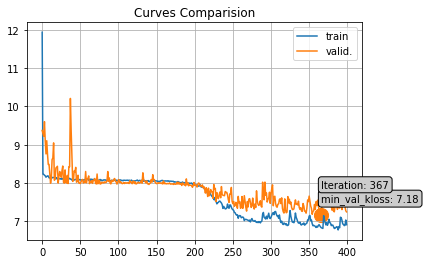

In [66]:
plt.plot(history.history['kloss'])
plt.plot(history.history['val_kloss'])
plt.legend(['train', 'valid.'])
plt.grid()
plt.title("Curves Comparision")
#finding and plotting the min val_kloss value
min_val_kloss=np.min(history.history['val_kloss'])
x_min_val_kaloss=np.where(history.history['val_kloss']==np.min(history.history['val_kloss']))[0][0]
plt.scatter(x_min_val_kaloss,min_val_kloss, c='#ff7f0e', s=200)
bbox = dict(boxstyle="round", fc="0.8")
plt.annotate("min_val_kloss: "+str(np.round(min_val_kloss, decimals=2)), (x_min_val_kaloss,min_val_kloss+0.35),bbox=bbox)
plt.annotate("Iteration: "+str(x_min_val_kaloss+1), (x_min_val_kaloss,min_val_kloss+0.7),bbox=bbox)
plt.show()

In [67]:
# The model weights (that are considered the best) are loaded into the model.
net.load_weights('./weights.h5')

In [68]:
#pred = net.predict([xs, z], batch_size=100, verbose=1)

In [69]:
pred = net.predict(xs, batch_size=100, verbose=1)

13/13 [==============================] - 3s 251ms/step


In [70]:
sigma_opt = mean_absolute_error(y, pred[:, 0])
sigma_mean = np.mean(pred[:, 1])
print(sigma_opt, sigma_mean)

132.25791597714954 223.72575


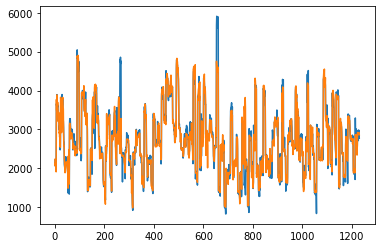

In [71]:
plt.plot(y)
plt.plot(pred[:, 0])
#plt.plot(pred[:, 1])

In [72]:
pred[:, 1].min(), pred[:, 1].max()

(82.43481, 403.64948)

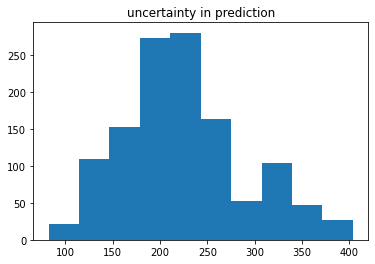

In [73]:
plt.hist(pred[:, 1])
plt.title("uncertainty in prediction")
plt.show()

### PREDICTION

In [74]:
xe, df_te = get_images(sub, how="test")
df_te = df_te.merge(sub, how="left", on=['Patient', 'Weeks'])

100%|██████████| 730/730 [00:07<00:00, 95.29it/s] 


In [75]:
x_te = xe - x_min / (x_max - x_min)
#Adding new dimenssion
x_te = np.expand_dims(x_te, axis=3)
ze = df_te[FE].values

In [76]:
#Repeating image in order to create a new dataset x_te with 3 channels
temp2=np.zeros((x_te.shape[0],x_te.shape[1],x_te.shape[2],3))
print(temp2.shape)
#Now we create a new for cycle in order to assign new data
for i in range(3):
    temp2[:,:,:,i] = x_te[:,:,:,0]
x_te=temp2

(489, 128, 128, 3)


In [77]:
#pe = net.predict([x_te, ze], batch_size=100, verbose=1)
pe = net.predict(x_te, batch_size=100, verbose=1)

5/5 [==============================] - 2s 330ms/step


In [78]:
df_te['FVC1'] = pe[:, 0]
df_te['Confidence1'] = pe[:, 1]

In [79]:
sub = sub.merge(df_te[['Patient','Weeks','FVC1','Confidence1']], how='left', 
                on=['Patient', 'Weeks'])
#====================================================#

In [80]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent,FVC1,Confidence1
0,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,0,1,0,0,0.615385,0.3724,0.067901,0.332421,NaN,NaN
1,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,0,1,0,0,0.615385,0.3724,0.074074,0.332421,NaN,NaN
2,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,0,1,0,0,0.615385,0.3724,0.080247,0.332421,NaN,NaN
3,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,0,1,0,0,0.615385,0.3724,0.086420,0.332421,NaN,NaN
4,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,0,1,0,0,0.615385,0.3724,0.092593,0.332421,NaN,NaN


In [81]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [82]:
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
13,ID00419637202311204720264_1,3020,100.0,3096.950195,255.638504
14,ID00419637202311204720264_2,3020,100.0,3085.274902,254.682144
15,ID00419637202311204720264_3,3020,100.0,3046.104980,251.473343
16,ID00419637202311204720264_4,3020,100.0,3021.783936,249.481003
17,ID00419637202311204720264_5,3020,100.0,3018.192139,249.186783
18,ID00419637202311204720264_6,3020,100.0,3023.476074,249.619705
19,ID00419637202311204720264_7,3020,100.0,2905.013184,239.915176
20,ID00419637202311204720264_8,3020,100.0,2753.639160,227.514664
21,ID00419637202311204720264_9,3020,100.0,2753.959961,227.541031
22,ID00419637202311204720264_10,3020,100.0,2759.013916,227.954971


In [83]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']
    subm.loc[subm.FVC1.isnull(),'Confidence'] = sigma_opt
#

In [84]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
0,ID00419637202311204720264_-12,3020.0,132.257916,NaN,NaN
1,ID00419637202311204720264_-11,3020.0,132.257916,NaN,NaN
2,ID00419637202311204720264_-10,3020.0,132.257916,NaN,NaN
3,ID00419637202311204720264_-9,3020.0,132.257916,NaN,NaN
4,ID00419637202311204720264_-8,3020.0,132.257916,NaN,NaN


In [85]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2625.715236,394.950382,1664.887207,2310.603638,2739.000000,2990.743042,3294.000000
Confidence,730.0,182.361428,43.795264,132.257916,132.257916,180.770950,226.398190,260.859680
FVC1,489.0,2503.884277,388.804779,1664.887207,2178.037109,2524.727539,2862.464600,3160.676758
Confidence1,489.0,207.054535,31.851177,138.319427,180.361099,208.761963,236.429733,260.859680


In [86]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [87]:
tf.version.VERSION

'2.2.0'

In [ ]:
keras.__version__

In [ ]:
import os
os.chdir(r'../working')
from IPython.display import FileLink
FileLink(r'./weights.h5')